# Setup

In [ ]:
%%shell
#git clone https://github.com/rapidsai/rapidsai-csp-utils.git
#python rapidsai-csp-utils/colab/pip-install.py
#git clone https://github.com/Xtra-Computing/thundersvm.git
#cd thundersvm && mkdir build && cd build && cmake .. && make -j
#python /content/thundersvm/python/setup.py install
#pip install faiss-cpu
pip install chronos-forecasting tqdm kaggle

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/thundersvm-0.3.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Using cached chronos_forecasting-1.5.0-py3-none-any.whl.metadata (30 kB)
  Using cached accelerate-0.34.2-py3-none-any.whl.metadata (19 kB)
  Using cached transformers-4.47.1-py3-none-any.whl.metadata (44 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
Using cached chronos_forecasting-1.5.0-py3-none-any.whl (29 kB)
Using cached accelerate-0.34.2-py3-none-any.whl (324 kB)
Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
Using 

In [ ]:
import pandas as pd
import torch
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import zipfile
import os
import shutil
import sys
import tqdm as tqdm
#import faiss
import torch.nn as nn

from transformers import AutoModel
from typing import List, Union, Optional
from chronos import ChronosPipeline
from torch.utils.data import DataLoader
from torch import optim
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, auc, precision_score, average_precision_score, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, fbeta_score, log_loss, accuracy_score
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid #, GridSearchCV
#from cuml.model_selection import GridSearchCV
#from cuml.ensemble import RandomForestClassifier
#from cuml.svm import SVC
from google.colab import drive
from importlib.machinery import SourceFileLoader


drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/Freqtrade')

from utils import *

Mounted at /content/drive


## Load data

In [ ]:
# Source path of the kaggle.json file
kaggle_json_path = '/content/drive/MyDrive/kaggle.json'

# Destination path within the kaggle directory
destination_path = '/root/.kaggle/kaggle.json'

# Create the .kaggle directory if it doesn't exist
os.makedirs('/root/.kaggle', exist_ok=True)

# Copy the file to the destination
shutil.copy2(kaggle_json_path, destination_path)

# Set appropriate permissions for the copied file
os.chmod(destination_path, 0o600)

In [ ]:
!kaggle datasets download -d novandraanugrah/bitcoin-historical-datasets-2018-2024

Dataset URL: https://www.kaggle.com/datasets/novandraanugrah/bitcoin-historical-datasets-2018-2024
License(s): CC0-1.0
 94% 15.0M/16.0M [00:01<00:00, 14.4MB/s]
100% 16.0M/16.0M [00:01<00:00, 10.6MB/s]


In [ ]:
labels_path = '/content/drive/MyDrive/Freqtrade/datos/labels_BTC.csv'

with zipfile.ZipFile('bitcoin-historical-datasets-2018-2024.zip', 'r') as zip_ref:
    zip_ref.extractall()

#df_btc = pd.read_csv('btc_1h_data_2018_to_2024-2024-12-10.csv')
df_btc = pd.read_csv('btc_1h_data_2018_to_2025.csv')
df_btc = df_btc.loc[:, ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
df_btc.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
df_btc['date'] = pd.to_datetime(df_btc['date'], utc=True)

df_labels = pd.read_csv(labels_path, parse_dates=['startDate', 'endDate'])

In [ ]:
window_size = 48
cols = ['close']
df_processed = process_dataframe(df_btc, lags=window_size, cols=cols, apply_pct_change=False)

df_merge = pd.merge(df_processed, df_labels[['startDate', 'endDate', 'label', 'profit_curado']], left_index=True, right_on='startDate', how='inner')
df_merge.set_index('startDate', inplace=True)
df_merge.head()

,close_1,close_2,close_3,close_4,close_5,close_6,close_7,close_8,close_9,close_10,...,close_42,close_43,close_44,close_45,close_46,close_47,close_48,endDate,label,profit_curado
startDate,,,,,,,,,,,,,,,,,,,,,
2018-01-03 01:00:00+00:00,13203.06,13330.18,13410.03,13601.01,13558.99,13780.41,13570.35,13499.99,13616.99,13570.01,...,14580.00,14732.75,14751.00,14692.40,14799.96,14675.11,14774.53,2018-01-03 03:00:00+00:00,0,0
2018-01-03 02:00:00+00:00,13330.18,13410.03,13601.01,13558.99,13780.41,13570.35,13499.99,13616.99,13570.01,13220.56,...,14732.75,14751.00,14692.40,14799.96,14675.11,14774.53,14820.00,2018-01-05 02:00:00+00:00,0,0
2018-01-03 03:00:00+00:00,13410.03,13601.01,13558.99,13780.41,13570.35,13499.99,13616.99,13570.01,13220.56,13172.42,...,14751.00,14692.40,14799.96,14675.11,14774.53,14820.00,15008.07,2018-01-03 06:00:00+00:00,1,0
2018-01-03 04:00:00+00:00,13601.01,13558.99,13780.41,13570.35,13499.99,13616.99,13570.01,13220.56,13172.42,13017.00,...,14692.40,14799.96,14675.11,14774.53,14820.00,15008.07,14818.49,2018-01-05 04:00:00+00:00,0,0
2018-01-03 05:00:00+00:00,13558.99,13780.41,13570.35,13499.99,13616.99,13570.01,13220.56,13172.42,13017.00,13211.39,...,14799.96,14675.11,14774.53,14820.00,15008.07,14818.49,15019.66,2018-01-05 05:00:00+00:00,0,0


In [ ]:
exclude_cols = ['endDate', 'profit_curado', 'label']
start = pd.to_datetime("2020-01-01", utc=True)
end = pd.to_datetime("2024-01-01", utc=True)

df_full = df_merge[df_merge.index >= start]
df_dev = df_merge[(df_merge.index >= start) & (df_merge.index < end)]
df_test = df_merge[df_merge.index >= end]

X_dev, y_dev = df_dev.drop(exclude_cols,axis=1), df_dev['profit_curado']
X_test, y_test = df_test.drop(exclude_cols,axis=1), df_test['profit_curado']
all = pd.concat([X_dev, X_test])

X = torch.tensor(all.values)
X_dev_tensor, X_test_tensor = torch.tensor(X_dev.values), torch.tensor(X_test.values)

X.shape, X_dev_tensor.shape, X_test_tensor.shape

(torch.Size([43950, 48]), torch.Size([35032, 48]), torch.Size([8918, 48]))

## Model

In [ ]:
class ChronosEmbeddingExtractor(ChronosPipeline):
    def extract_embeddings(
        self,
        context: Union[torch.Tensor, List[torch.Tensor]],
        batch_size: int = 16
    ) -> torch.Tensor:
        """
        Extract embeddings from the Chronos encoder for a batch of time series.

        Parameters
        ----------
        context
            Input series. This is a list
            of 1D tensors, or a 2D tensor whose first dimension
            is batch.
        batch_size
            The size of the minibatches

        Returns
        -------
        embeddings
            Tensor of embeddings, of shape (batch_size, emb_size).
        """
        data_loader = DataLoader(context, batch_size=batch_size, shuffle=False)

        # Extract and pool embeddings for each batch
        embeddings = [self.embed(x)[0].mean(dim=1) for x in data_loader]
        embeddings = torch.cat(embeddings, dim=0)

        return embeddings

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

embedding_extractor = ChronosEmbeddingExtractor.from_pretrained(
    "amazon/chronos-t5-small",
    device_map=device,
    torch_dtype=torch.bfloat16,
)

embedding_extractor.model.device

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

device(type='cpu')

In [ ]:
#start = time.time()
#embeddings = embedding_extractor.extract_embeddings(X, 32)
#
#print(embeddings.shape)
#print(f'Total time: {time.time() - start:.2f}s')
#
#df_embeddings = pd.DataFrame(embeddings.to(torch.float32).numpy())
#df_embeddings.index = all.index
#df_embeddings.to_csv('embeddings_512.csv')

#Train

In [ ]:
# Compute embeddings
#X_np = embedding_extractor.extract_embeddings(X, 32).to(torch.float32).numpy()
#X_dev_np = embedding_extractor.extract_embeddings(X_dev_tensor, 32).to(torch.float32).numpy()
#X_test_np = embedding_extractor.extract_embeddings(X_test_tensor, 32).to(torch.float32).numpy()
#
#y_dev_np = y_dev.to_numpy()
#y_test_np = y_test.to_numpy()

In [ ]:
#df_emb = pd.DataFrame(X_np)
#df_emb.index = df_full.index
#df_emb = pd.concat([df_emb, df_full[['endDate', 'label', 'profit_curado']]], axis=1)
#df_emb.head()

## SVM

In [ ]:
#thundersvm = SourceFileLoader("thundersvm", "/content/thundersvm/python/thundersvm/thundersvm.py").load_module()
#rom thundersvm import SVC

In [ ]:
np.random.seed(42)

param_grid = {
    'kernel': ['poly', 'rbf', 'linear', 'sigmoid'],
    'C': [0.01, 1.0, 10.0]
}

results = []

for params in tqdm(ParameterGrid(param_grid)):

    svc = SVC(probability=True, **params)
    svc.fit(X_dev_np, y_dev_np)

    y_pred_proba_train = svc.predict_proba(X_dev_np)[:, 1]
    auc_score_train = roc_auc_score(y_dev_np, y_pred_proba_train)

    y_pred_proba_test = svc.predict_proba(X_test_np)[:, 1]
    auc_score_test = roc_auc_score(y_test_np, y_pred_proba_test)

    results.append({
        'params': params,
        'roc_auc_train': auc_score_train,
        'roc_auc_test': auc_score_test
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='roc_auc_test', ascending=False)

results_df

 17%|█▋        | 2/12 [00:23<01:47, 10.71s/it]

[W] [18:14:28.301340] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.


100%|██████████| 12/12 [01:26<00:00,  7.18s/it]


,params,roc_auc_train,roc_auc_test
7,"{'C': 1.0, 'kernel': 'sigmoid'}",0.613178,0.564017
4,"{'C': 1.0, 'kernel': 'poly'}",0.747758,0.563496
5,"{'C': 1.0, 'kernel': 'rbf'}",0.736471,0.562180
10,"{'C': 10.0, 'kernel': 'linear'}",0.693683,0.561112
6,"{'C': 1.0, 'kernel': 'linear'}",0.674012,0.558544
11,"{'C': 10.0, 'kernel': 'sigmoid'}",0.567773,0.553888
9,"{'C': 10.0, 'kernel': 'rbf'}",0.836761,0.553444
8,"{'C': 10.0, 'kernel': 'poly'}",0.851543,0.553332
0,"{'C': 0.01, 'kernel': 'poly'}",0.665706,0.551578
2,"{'C': 0.01, 'kernel': 'linear'}",0.658960,0.549056


In [ ]:
np.random.seed(42)

svc = SVC(probability=True, **results_df.iloc[0]['params'])
svc.fit(X_dev_np, y_dev_np)

y_pred_proba = svc.predict_proba(X_test_np)[:, 1]
roc_auc = roc_auc_score(y_test_np, y_pred_proba)

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.5640


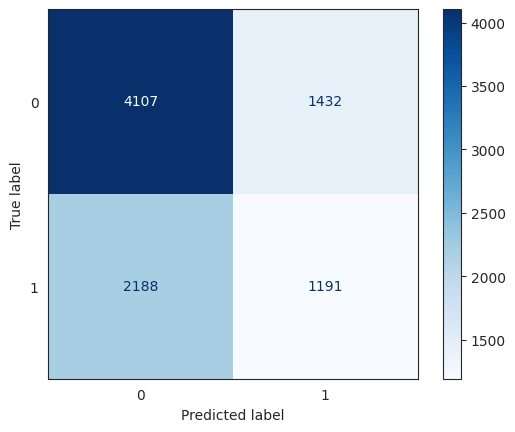

In [ ]:
cm = confusion_matrix(y_test_np, (y_pred_proba >= 0.41).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

sns.set_style("white")
disp.plot(cmap='Blues')

## Random Forest

In [ ]:
# Define TimeSeriesSplit with a gap
tscv = TimeSeriesSplit(n_splits=5, gap=200)

# Define the parameter grid
param_grid = {
    "max_depth": [3, 5, 8],
    "min_samples_split": [2, 5, 10],  # Minimum samples required to split a node
    "min_samples_leaf": [5, 10, 25]
}

# Define the model
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=tscv,
    n_jobs=-1,
    return_train_score=True
)

# Perform the grid search
start_time = time.time()
grid_search.fit(X_dev_np, y_dev_np)
print(f"GridSearchCV completed in {(time.time() - start_time)/60:1f}m")

# Collect results in a DataFrame
cols = ['mean_train_score', 'mean_test_score', 'params'] + [col for col in results_df.columns if col.startswith('param_')]
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)
results_df = results_df[cols]

results_df.head(10)

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


GridSearchCV completed in 1.485251m


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
13,0.944128,0.106956,0.022188,0.007413,5,10,5,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_...",0.604485,0.616622,...,0.597363,0.032412,1,0.951815,0.904437,0.869401,0.838026,0.820937,0.876923,0.047053
14,1.173214,0.293537,0.025729,0.007660,5,10,10,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_...",0.604485,0.616622,...,0.597363,0.032412,1,0.951815,0.904437,0.869401,0.838026,0.820937,0.876923,0.047053
12,1.029441,0.066623,0.018221,0.001271,5,10,2,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_...",0.604485,0.616622,...,0.597363,0.032412,1,0.951815,0.904437,0.869401,0.838026,0.820937,0.876923,0.047053
11,0.950983,0.078340,0.018049,0.002248,5,5,10,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...",0.605161,0.617287,...,0.597311,0.032796,4,0.952937,0.905100,0.869971,0.838598,0.821107,0.877543,0.047334
9,1.108722,0.174694,0.030352,0.002221,5,5,2,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...",0.605161,0.617287,...,0.597311,0.032796,4,0.952937,0.905100,0.869971,0.838598,0.821107,0.877543,0.047334
10,0.978974,0.085676,0.020819,0.006352,5,5,5,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...",0.605161,0.617287,...,0.597311,0.032796,4,0.952937,0.905100,0.869971,0.838598,0.821107,0.877543,0.047334
17,0.974917,0.137964,0.020338,0.002892,5,25,10,"{'max_depth': 5, 'min_samples_leaf': 25, 'min_...",0.606579,0.615543,...,0.597234,0.033337,7,0.947891,0.902187,0.867042,0.836452,0.819810,0.874676,0.046145
16,1.053003,0.291720,0.018567,0.002164,5,25,5,"{'max_depth': 5, 'min_samples_leaf': 25, 'min_...",0.606579,0.615543,...,0.597234,0.033337,7,0.947891,0.902187,0.867042,0.836452,0.819810,0.874676,0.046145
15,1.167031,0.304157,0.033914,0.006917,5,25,2,"{'max_depth': 5, 'min_samples_leaf': 25, 'min_...",0.606579,0.615543,...,0.597234,0.033337,7,0.947891,0.902187,0.867042,0.836452,0.819810,0.874676,0.046145
25,1.326783,0.241137,0.046161,0.012487,8,25,5,"{'max_depth': 8, 'min_samples_leaf': 25, 'min_...",0.602474,0.624494,...,0.594920,0.040969,10,0.990452,0.981796,0.972385,0.963011,0.952810,0.972091,0.013309


In [ ]:
best_params = results_df.iloc[0]['params']

# Fit the model using the best parameters
rf_best = RandomForestClassifier(n_estimators=200, random_state=42, **best_params)
rf_best.fit(X_dev_np, y_dev_np)

# Predict using the trained model
y_pred = rf_best.predict(X_test_np)
y_pred_proba = rf_best.predict_proba(X_test_np)[:, 1]

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams=1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  return func(**kwargs)


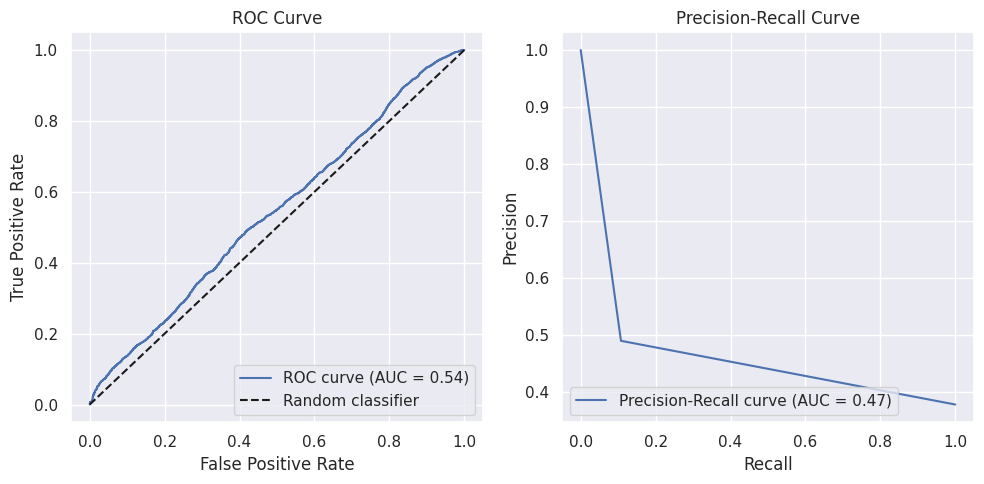

In [ ]:
sns.set_theme()

# Compute ROC curve
fpr_roc, tpr_roc, _ = roc_curve(y_test_np, y_pred_proba)
roc_auc = roc_auc_score(y_test_np, y_pred_proba)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test_np, y_pred)
precision_recall_auc = auc(recall, precision)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ROC Curve
ax1.plot(fpr_roc, tpr_roc, label='ROC curve (AUC = %0.2f)' % roc_auc)
ax1.plot([0, 1], [0, 1], 'k--', label='Random classifier')  # y=x dashed line
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc='lower right')

# Precision-Recall Curve
ax2.plot(recall, precision, label='Precision-Recall curve (AUC = %0.2f)' % precision_recall_auc)
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc='lower left')

plt.tight_layout()
plt.show()

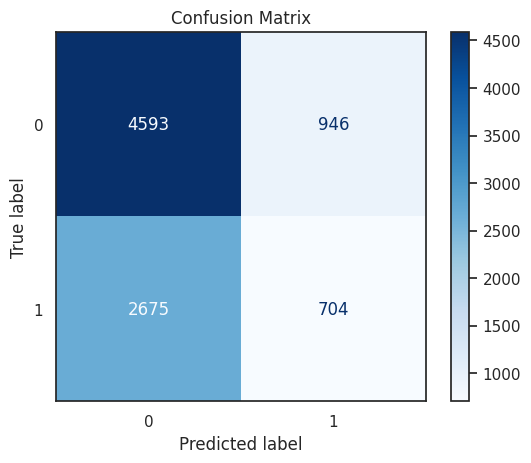

In [ ]:
y_pred_labels = (y_pred_proba >= 0.45).astype(int)

cm = confusion_matrix(y_test_np, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

sns.set_style("white")
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## KNN

In [ ]:
class FaissKNNClassifier:
    """A multiclass exact KNN classifier implemented using the FAISS library."""

    def __init__(
        self, n_neighbors: int, n_classes: Optional[int] = None, device: str = "cpu"
    ) -> None:
        """Instantiate a faiss KNN Classifier.

        Args:
            n_neighbors: number of KNN neighbors
            n_classes: (optional) number of dataset classes
                (otherwise derive from the data)
            device: a torch device, e.g. cpu, cuda, cuda:0, etc.
        """
        self.n_neighbors = n_neighbors
        self.n_classes = n_classes

        if device == "cpu":
            self.cuda = False
            self.device = None
        else:
            self.cuda = True
            if ":" in device:
                self.device = int(device.split(":")[-1])
            else:
                self.device = 0

    def create_index(self, d: int) -> None:
        """Create the faiss index.

        Args:
            d: feature dimension
        """
        if self.cuda:
            self.res = faiss.StandardGpuResources()
            self.config = faiss.GpuIndexFlatConfig()
            self.config.device = self.device
            self.index = faiss.GpuIndexFlatL2(self.res, d, self.config)
        else:
            self.index = faiss.IndexFlatL2(d)

    def fit(self, X: np.ndarray, y: np.ndarray) -> object:
        """Store train X and y.

        Args:
            X: input features (N, d)
            y: input labels (N, ...)

        Returns:
            self
        """
        X = np.atleast_2d(X).astype(np.float32)
        X = np.ascontiguousarray(X)
        self.create_index(X.shape[-1])
        self.index.add(X)
        self.y = y.astype(int)
        if self.n_classes is None:
            self.n_classes = len(np.unique(y))
        return self

    def __del__(self) -> None:
        """Cleanup helpers."""
        if hasattr(self, "index"):
            self.index.reset()
            del self.index
        if hasattr(self, "res"):
            self.res.noTempMemory()
            del self.res

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict int labels given X.

        Args:
            X: input features (N, d)

        Returns:
            preds: int predicted labels (N,)
        """
        X = np.atleast_2d(X).astype(np.float32)
        _, idx = self.index.search(X, self.n_neighbors)
        class_idx = self.y[idx]
        counts = np.apply_along_axis(
            lambda x: np.bincount(x, minlength=self.n_classes),
            axis=1,
            arr=class_idx.astype(np.int16),
        )
        preds = np.argmax(counts, axis=1)
        return preds, idx

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """Predict float probabilities for labels given X.

        Args:
            X: input features (N, d)

        Returns:
            preds_proba: float probas per labels (N, c)
        """
        X = np.atleast_2d(X).astype(np.float32)
        _, idx = self.index.search(X, self.n_neighbors)
        class_idx = self.y[idx]
        counts = np.apply_along_axis(
            lambda x: np.bincount(x, minlength=self.n_classes),
            axis=1,
            arr=class_idx.astype(np.int16),
        )

        preds_proba = counts / self.n_neighbors
        return preds_proba, idx

def get_n_closest(data, startDate, n=2500, starting_count=48):
    previous_data = data[data['endDate'] < startDate - pd.Timedelta(hours=starting_count)]
    previous_data = previous_data.sort_values(by='endDate', ascending=False)
    res = previous_data.head(n)

    drop_cols = ['endDate', 'label', 'profit_curado']
    X_train, y_train = res.drop(columns=drop_cols), res['profit_curado']

    return np.array(X_train), np.array(y_train), np.array(res.index)

In [ ]:
res = {'pred_probas': [], 'labels': []}
k = 7
n_points = 2500
N = 3000
dates = df_test.index[:N]

for date in tqdm(dates):
    X, y, _ = get_n_closest(df_emb, date, n=n_points)
    current_data = np.array(df_emb.loc[date].drop(['endDate', 'label', 'profit_curado']))

    if len(y) == n_points:
        knn_clf = FaissKNNClassifier(n_neighbors=k)
        knn_clf.fit(X, y)
        pred_proba, idx = knn_clf.predict_proba(current_data)
        pred_proba = np.squeeze(pred_proba, axis=0)
        label = df_emb.loc[date, 'profit_curado']
        res['pred_probas'].append(pred_proba)
        res['labels'].append(label)

100%|██████████| 3000/3000 [05:36<00:00,  8.91it/s]


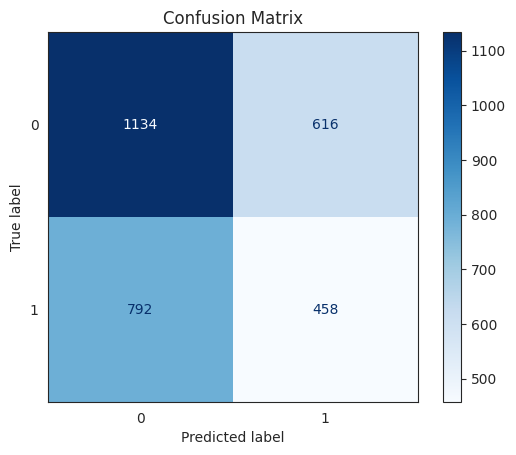

0.5109382857142857


In [ ]:
labels = np.array(res['labels'])
pred_probas = np.array(res['pred_probas'])[:,1]

roc_auc = roc_auc_score(labels, pred_probas)
cm = confusion_matrix(labels, (pred_probas >= 4/7).astype(int))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

sns.set_style("white")
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
print(roc_auc)

## Chronos

In [ ]:
class ChronosClassifier(nn.Module):
    def __init__(self, model_name="amazon/chronos-t5-small", device='cuda', dtype=torch.bfloat16):
        super().__init__()
        self.pipeline = ChronosPipeline.from_pretrained(model_name, device_map=device, torch_dtype=dtype)
        self.model = self.pipeline.model.model

        # Add a linear layer for classification
        self.classifier = nn.Linear(self.model.shared.embedding_dim, 1, device=device, dtype=dtype)

    def forward(self, input_ids):
        embeddings, _ = self.pipeline.embed(input_ids)
        logits = self.classifier(embeddings.mean(dim=1)) # Mean pool embeddings
        return logits


chronos_clf = ChronosClassifier("amazon/chronos-t5-small", device='cpu')

In [ ]:
for param in chronos_clf.model.parameters():
    param.requires_grad = False

# Unfreeze only embedding layers
chronos_clf.model.shared.weight.requires_grad = True
chronos_clf.model.encoder.embed_tokens.weight.requires_grad = True

# Count trainable parameters
num_trainable_params = sum(p.numel() for p in chronos_clf.parameters() if p.requires_grad)
print(f"Number of parameters to be optimized: {num_trainable_params}")

# Count frozen parameters
num_frozen_params = sum(p.numel() for p in chronos_clf.parameters() if not p.requires_grad)
print(f"Number of frozen parameters: {num_frozen_params}")

optimizer = optim.AdamW(chronos_clf.parameters(), lr=1e-3)

Number of parameters to be optimized: 2097409
Number of frozen parameters: 44057088


In [ ]:
def trainer(train_dataset, val_dataset, model, args):
    torch.manual_seed(42)

    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model = model.to(args['dtype'])

    # Loss function
    loss_fn = BCEWithLogitsLoss().to(device)

    # DataLoader arguments
    train_kwargs = {'pin_memory': True, 'batch_size': args['batch_size'], 'shuffle': True}
    val_kwargs = {'pin_memory': True, 'batch_size': args['batch_size'], 'shuffle': False}

    # Create DataLoader for training and validation sets
    train_loader = DataLoader(train_dataset, **train_kwargs, drop_last=True)
    val_loader = DataLoader(val_dataset, **val_kwargs)

    # Optimizer
    optimizer = torch.optim.AdamW(params=filter(lambda p: p.requires_grad, model.parameters()),
                                  lr=args['lr'], weight_decay=args['weight_decay'])

    best_val_auc = 0.0
    best_model_state = None

    # Store metrics for plotting later
    history = {
        'train_loss': [],
        'train_acc': [],
        'train_auc': [],
        'val_loss': [],
        'val_acc': [],
        'val_auc': []
    }

    # Training loop
    for epoch in tqdm(range(args['epochs']), initial=1, desc="Training Epochs"):

        # Training phase
        model.train()
        train_loss = 0.0
        train_pred_probas, train_labels = [], []

        for batch in train_loader:
            optimizer.zero_grad()

            # Extract input and labels from batch (adjust based on your dataset structure)
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            logits = model(input_ids)

            # Calculate loss
            loss = loss_fn(logits.squeeze(-1), labels.float())
            train_loss += loss.item()

            # Backward pass
            loss.backward()
            optimizer.step()

            # Collect predictions and labels for accuracy and ROC-AUC calculation
            train_pred_probas.extend(torch.sigmoid(logits).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

            # Clear CUDA cache to avoid memory overflow
            torch.cuda.empty_cache()

        # Calculate accuracy and ROC-AUC for training
        train_pred_probas = torch.tensor(train_pred_probas)
        train_labels = torch.tensor(train_labels)
        train_acc = accuracy_score(train_labels, train_pred_probas.round())
        train_auc = roc_auc_score(train_labels, train_pred_probas)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_pred_probas, val_labels = [], []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                logits = model(input_ids)

                # Calculate loss
                loss = loss_fn(logits.squeeze(-1), labels.float())
                val_loss += loss.item()

                # Collect predictions and labels for accuracy and ROC-AUC calculation
                val_pred_probas.extend(torch.sigmoid(logits).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

                # Clear CUDA cache to avoid memory overflow
                torch.cuda.empty_cache()

        # Calculate accuracy and ROC-AUC for validation
        val_pred_probas = torch.tensor(val_pred_probas)
        val_labels = torch.tensor(val_labels)
        val_acc = accuracy_score(val_labels, val_pred_probas.round())
        val_auc = roc_auc_score(val_labels, val_pred_probas)

        # Store metrics for plotting later
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_acc)
        history['train_auc'].append(train_auc)
        history['val_loss'].append(val_loss / len(val_loader))
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)

        # Print metrics
        print(f"Epoch [{epoch}/{args['epochs']}] | "
              f"Train Loss: {train_loss/len(train_loader):.3f} | "
              f"Train Accuracy: {train_acc:.3f} | "
              f"Train ROC-AUC: {train_auc:.3f} | "
              f"Val Loss: {val_loss/len(val_loader):.3f} | "
              f"Val Accuracy: {val_acc:.3f} | "
              f"Val ROC-AUC: {val_auc:.3f}")

        # Save the best model based on validation ROC-AUC
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict()

    # Load the best model
    model.load_state_dict(best_model_state)

    # Return both model and the history for later plotting
    return model, history

In [ ]:
train_loader = DataLoader(X_dev_tensor, batch_size=2, shuffle=True, pin_memory=True)
chronos_clf(next(iter(train_loader)))

tensor([[-0.0391],
        [-0.0403]], dtype=torch.bfloat16, grad_fn=<AddmmBackward0>)